# Data Loading and Cleaning
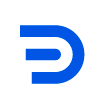

## In this workbook, I will load and clean the data sets from Twitter. One element of this is seperating the hashtags from the data source for analysis and matching them up to a list of predefined conspiracy hashtags

## Downloads
### Downloads

In [1]:
# imports
import os
import itertools
import collections
from collections import Counter
import re
import numpy as np

import tweepy as tw
import pandas as pd
import string

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# download stopwords, punkt and wordnet packages
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
# API key
api_key = config.api_key
secret = config.secret

In [4]:
auth = tw.AppAuthHandler(api_key, secret)
api = tw.API(auth, wait_on_rate_limit=True)

### Define the Key Search Terms 

In [5]:
# define hashtag search terms
# NB: they are case sensitive
search_coronavirus = '#coronavirus'
search_covid = '#covid'
search_covid19 = '#covid19'
search_virus = '#virus'
search_vaccine = '#vaccine'
search_pandemic = '#pandemic'

# # Other Options to search
# search_vaccine = '#vaccine'
# search_vaccinated = '#vaccinated'
# search_vaccination = '#vaccination'
# search_jab = '#jab'
# search_pfizer = '#pfizer'
# search_astrazeneca = '#astrazeneca'
# search_moderna = '#moderna'

## Dataframes Cleaned and Saved

### Cleaning 

In [6]:
# Cleaning function
def tweet_clean(df):
# remove emojis from the text
    def remove_emoji(string):
        emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F" # emoticons
                            u"\U0001F300-\U0001F5FF" # symbols & pictographs
                            u"\U0001F680-\U0001F6FF" # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', string)
# REGEX function   
    def regex_clean(txt, regex):
        return " ".join(re.sub(regex, "", txt).split())
# lemmatize tweet
    lemmatizer = WordNetLemmatizer()
    stpwrd = nltk.corpus.stopwords.words('english')
    stpwrd.extend(string.punctuation)
    def lemmatize_data(n):
        n = n.lower() 
        n = regex_clean(n, r'\s\d+\s')
        n = word_tokenize(n)
        n = [lemmatizer.lemmatize(word) for word in n]
        n = [lemmatizer.lemmatize(word) for word in n if word not in stpwrd]
        return n
# stem tweet
    p_stemmer = PorterStemmer()
    def stem_data(n):
        n = n.lower() 
        n = regex_clean(n, r'\s\d+\s')
        n = word_tokenize(n)
        n = [p_stemmer.stem(word) for word in n]
        n = [p_stemmer.stem(word) for word in n if word not in stpwrd]
        return n
# lancaster stem tweet
    def lanc_stemmed(df):
        df['split'] = df['cleaned'].apply(lambda x: str(x).lower())
        df['split'] = df.split
        df['split'].replace('^[0-9]+$','',inplace=True)
        for punc in string.punctuation:
            df['split'] = df.split.str.replace(punc,'')
        df['split'] = df['split'].apply(lambda x: [item for item in str(x).split() if item not in stopwords.words('english')])
        df['split'] = df['split'].apply(lambda x: [LancasterStemmer().stem(a) for a in x])
        return df

# apply cleaning functions to dataframe
# find all hashtags
    df['hashtag'] = df['tweet'].apply(lambda x: re.findall(r"#(\w+)", x))
# clean dataframe
    df['cleaned'] = df['tweet'].apply(str.lower)
  
    regex_to_clean = ['(@.+?)\s',
                      '\s\d+\s']
    for reg in regex_to_clean:
        df['cleaned'] = df['cleaned'].apply(regex_clean, regex=reg)
        df['cleaned'] = df['cleaned'].apply(remove_emoji)
# tokenize tweet  
    df['tokens'] = df['cleaned'].apply(word_tokenize)
# lemmatize tweet  
    df['lemmatized'] = df['cleaned'].apply(lemmatize_data)
# stem tweet
    df['stemmed'] = df['cleaned'].apply(stem_data)
# lancaster stem tweet
    df = lanc_stemmed(df)
# return cleaned dataframe
    return df

### Coronavirus Dataframe Cleaned and Saved

In [7]:
## call a cursor item in the twitter library
# use api search
# this item generator collects 1000 items and if we loop through it we can collect all 1000 of our tweets in a dataframe
######### SORT DATES
tweets_coronavirus = tw.Cursor(api.search,
                   q = search_coronavirus,
                   lang ='en',
                   fromDate = '202002010000',
                   toDate = '202118060000',
                   tweet_mode = 'extended',
                   min_retweets = 50,
                   result_type = 'mixed').items(1000)

tweets_coronavirus

In [8]:
# create dataframe
tweet_coronavirus = pd.DataFrame(data=[[tweet.full_text, tweet.user.screen_name, tweet.user.location, tweet.created_at, tweet.id, tweet.source, tweet.favorite_count, tweet.retweet_count, len(tweet.full_text)]for tweet in tweets_coronavirus])

In [9]:
# rename dataframe columns
tweet_coronavirus.columns = ['tweet', 'user', 'location', 'date', 'id', 'source', 'favourites', 'retweets', 'tweet_length']

In [10]:
tweet_coronavirus = tweet_clean(tweet_coronavirus)

In [11]:
#explore datatypes
tweet_coronavirus.dtypes

tweet                   object
user                    object
location                object
date            datetime64[ns]
id                       int64
source                  object
favourites               int64
retweets                 int64
tweet_length             int64
hashtag                 object
cleaned                 object
tokens                  object
lemmatized              object
stemmed                 object
split                   object
dtype: object

In [12]:
tweet_coronavirus

,tweet,user,location,date,id,source,favourites,retweets,tweet_length,hashtag,cleaned,tokens,lemmatized,stemmed,split
0,.@NIH officials worked with EcoHealth Alliance...,garyruskin,,2021-11-03 19:52:41,1455986309135171588,Twitter Web App,192,117,199,[coronavirus],.officials worked with ecohealth alliance to e...,"[.officials, worked, with, ecohealth, alliance...","[.officials, worked, ecohealth, alliance, evad...","[.offici, work, ecohealth, allianc, evad, rest...","[off, work, ecoheal, al, evad, restrict, coron..."
1,#Iran’s parliament acknowledges disastrous mis...,Mojahedineng,IRAN,2021-11-03 20:00:02,1455988156403265540,Twitter Web App,39,37,256,"[Iran, coronavirus]",#iran’s parliament acknowledges disastrous mis...,"[#, iran, ’, s, parliament, acknowledges, disa...","[iran, ’, parliament, acknowledges, disastrous...","[iran, ’, parliament, acknowledg, disastr, mis...","[iran’s, parlia, acknowledg, disast, mism, cor..."
2,"Iran News in Brief – November 4, 2021,\nIran: ...",iran_policy,"Tehran, Iran, Paris, France",2021-11-04 08:51:29,1456182298240487426,TweetDeck,52,52,242,"[Iran, ProsecuteRaisiNOW, coronavirus]","iran news in brief – november 4, 2021, iran: t...","[iran, news, in, brief, –, november, 4, ,, 202...","[iran, news, brief, –, november, 4, 2021, iran...","[iran, news, brief, –, novemb, 4, 2021, iran, ...","[ir, new, brief, –, novemb, 4, 2021, ir, stag,..."
3,RT @scarletmonahan: Alan 4 Things you must nev...,scarletmonahan,United Kingdom,2021-11-05 10:54:11,1456575566442795013,Twitter for Android,0,2,140,"[SocialDistancing, Dominicummimgs, covid19, co...",rt alanthings you must never do. https://t.co/...,"[rt, alanthings, you, must, never, do, ., http...","[rt, alanthings, must, never, http, //t.co/19r...","[rt, alanth, must, never, http, //t.co/19rwvd2...","[rt, alanth, must, nev, httpstco19rwvd25vw, so..."
4,7 Day US Covid Deaths by County For TX 2021...,njoyflyfishing,"Los Angeles, CA",2021-11-05 10:54:02,1456575526789845002,smcapplication,0,0,220,"[datavisualization, datascience, analytics, da...",7 day us covid deaths by county for tx 2021-11...,"[7, day, us, covid, deaths, by, county, for, t...","[7, day, u, covid, death, county, tx, 2021-11-...","[7, day, us, covid, death, counti, tx, 2021-11...","[7, day, us, covid, death, county, tx, 2021110..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,I'm joining with millions of people from all o...,ksmk8,United States,2021-11-03 17:04:24,1455943959146942473,Twitter for iPhone,0,0,228,"[GlobalCeasefire, Covid19Pandemic, Coronavirus]",i'm joining with millions of people from all o...,"[i, 'm, joining, with, millions, of, people, f...","['m, joining, million, people, world, standing...","['m, join, million, peopl, world, stand, chief...","[im, join, mil, peopl, world, stand, chief, bo..."
996,RT @GordonGChang: The #CCP for more than a yea...,marianturkin1,Poland,2021-11-03 17:04:22,1455943951752515588,Twitter Web App,0,92,140,"[CCP, America]",rt the #ccp for more than a year has been maki...,"[rt, the, #, ccp, for, more, than, a, year, ha...","[rt, ccp, year, ha, making, case, political, s...","[rt, ccp, year, ha, make, case, polit, system,...","[rt, ccp, year, mak, cas, polit, system, far, ..."
997,"Happy shopping,Happy life✨🎊🎁 #Diwali #Election...",ClothingRealm,Bangladesh,2021-11-03 17:04:15,1455943922652385282,Twitter Web App,1,0,298,"[Diwali, ElectionDay2021, HappyVirus, HEESEUNG...","happy shopping,happy life #diwali #electionday...","[happy, shopping, ,, happy, life, #, diwali, #...","[happy, shopping, happy, life, diwali, electio...","[happi, shop, happi, life, diwali, electionday...","[happy, shoppinghappy, lif, diwal, electionday..."
998,RT @TigressEllie: Sadly 😭 another child covid ...,JC32479437,,2021-11-03 17:04:14,1455943916801429506,Twitter Web App,0,310,140,[],rt sadly another child covid death in england ...,"[rt, sadly, another, child, covid, death, in, ...","[rt, sadly, another, child, covid, death, engl...","[rt, sadli, anot

In [13]:
#save dataframe to csv
from google.colab import files
tweet_coronavirus.to_csv('tweet_coronavirus.csv')
files.download("tweet_coronavirus.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Covid Dataframe Cleaned and Saved

In [14]:
tweets_covid = tw.Cursor(api.search,
                   q = search_covid,
                   lang ='en',
                   fromDate = '2020/02/01',
                   toDate = '2020/12/31',
                   tweet_mode = 'extended',
                   min_retweets = 50,
                   result_type = 'mixed').items(1000)

tweets_covid

In [15]:
tweet_covid = pd.DataFrame(data=[[tweet.full_text, tweet.user.screen_name, tweet.user.location, tweet.created_at, tweet.id, tweet.source, tweet.favorite_count, tweet.retweet_count, len(tweet.full_text)]for tweet in tweets_covid])

In [16]:
tweet_covid.columns = ['tweet', 'user', 'location', 'date', 'id', 'source', 'favourites', 'retweets', 'tweet_length']

In [17]:
tweet_covid = tweet_clean(tweet_covid)
tweet_covid

,tweet,user,location,date,id,source,favourites,retweets,tweet_length,hashtag,cleaned,tokens,lemmatized,stemmed,split
0,On the same day the @ongov includes healthcare...,drmwarner,"Toronto, Ontario",2021-11-03 21:35:39,1456012222589808641,Twitter Web App,3489,612,155,"[COVID, 3, 1]",on the same day the includes healthcare worker...,"[on, the, same, day, the, includes, healthcare...","[day, includes, healthcare, worker, priority, ...","[day, includ, healthcar, worker, prioriti, gro...","[day, includ, healthc, work, pri, group, covid..."
1,Reupping this in light of the inexplicable mov...,drmwarner,"Toronto, Ontario",2021-11-03 19:06:13,1455974615973572611,Twitter Web App,3159,750,243,[COVID],reupping this in light of the inexplicable mov...,"[reupping, this, in, light, of, the, inexplica...","[reupping, light, inexplicable, move, mandate,...","[reup, thi, light, inexpl, move, mandat, covid...","[reup, light, inexpl, mov, mand, covid, vaccin..."
2,"This festive season, let’s celebrate responsib...",SadhguruJV,India,2021-11-04 05:46:58,1456135863994179584,Twitter for Android,6393,1275,260,"[COVID, Diwali]","this festive season, let’s celebrate responsib...","[this, festive, season, ,, let, ’, s, celebrat...","[festive, season, let, ’, celebrate, responsib...","[thi, festiv, season, let, ’, celebr, respon, ...","[fest, season, let’s, celebr, respons, covid, ..."
3,Physicians and scientists should be able to sp...,chiche410,,2021-11-05 10:54:41,1456575690376204291,Twitter for iPhone,0,0,128,[covid],physicians and scientists should be able to sp...,"[physicians, and, scientists, should, be, able...","[physician, scientist, able, speak, debate, is...","[physician, scientist, abl, speak, debat, issu...","[phys, sci, abl, speak, deb, issu, without, fe..."
4,Pfizer says its Covid pill with HIV drug cuts ...,VSoien,🇬🇧,2021-11-05 10:54:35,1456575666355384320,Twitter for Android,0,0,140,"[COVID, HIV]",pfizer says its covid pill with hiv drug cuts ...,"[pfizer, says, its, covid, pill, with, hiv, dr...","[pfizer, say, covid, pill, hiv, drug, cut, ris...","[pfizer, say, covid, pill, hiv, drug, cut, ris...","[pfiz, say, covid, pil, hiv, drug, cut, risk, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Keep up with the daily #COVID numbers across #...,stevestockmar,"Peoria, AZ",2021-11-03 17:43:51,1455953885751693313,Twitter Web App,0,0,119,"[COVID, Arizona]",keep up with the daily #covid numbers across #...,"[keep, up, with, the, daily, #, covid, numbers...","[keep, daily, covid, number, across, arizona, ...","[keep, daili, covid, number, across, arizona, ...","[keep, dai, covid, numb, across, arizon, novp,..."
996,RT @WISN12News: WATCH: WISN 12's @WISN_Watson ...,JoyceGarbaciak,"Milwaukee, WI",2021-11-03 17:43:40,1455953840365346822,Twitter for iPhone,0,7,140,"[Packers, Rodgers, COVID]",rt watch: wisn 12's asks #packers head coach m...,"[rt, watch, :, wisn, 12, 's, asks, #, packers,...","[rt, watch, wisn, 12, 's, asks, packer, head, ...","[rt, watch, wisn, 12, 's, ask, packer, head, c...","[rt, watch, wisn, 12s, ask, pack, head, coach,..."
997,RT @Zubhaque: The REASON that we are in a *rac...,ChristineConsi3,,2021-11-03 17:43:27,1455953786141302791,Twitter for iPhone,0,200,144,[],rt the reason that we are in a *race* between ...,"[rt, the, reason, that, we, are, in, a, *race*...","[rt, reason, *race*, vaccination, booster, 1st...","[rt, reason, *race*, vaccin, booster, 1st, amp...","[rt, reason, rac, vaccin, boost, 1st, amp, 2nd..."
998,RT @Ocugen: #BREAKING:@WHO granted Emergency U...,KjgTrading,"Leicester, England",2021-11-03 17:43:24,1455953773227122690,Twitter for iPhone,0,339,140,"[BREAKING, COVID]",rt #breaking:granted emergency use listing app...,"[rt, #, breaking, :, granted, emergency, use, ...","[rt, breaking, granted, emergency, use, listin...","[rt, break, grant, emerg, use, list, approv, c...","[rt, breakinggr, emerg, us, list, approv, covi..."


In [18]:
# save to new csv
from google.colab import files
tweet_covid.to_csv('tweet_covid.csv')
files.download("tweet_covid.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Covid19 Dataframe Cleaned and Saved

In [19]:
tweets_covid19 = tw.Cursor(api.search,
                   q = search_covid19,
                   lang ='en',
                   fromDate = '2020/02/01',
                   toDate = '2020/12/31',
                   tweet_mode = 'extended',
                   min_retweets = 50,
                   result_type = 'mixed').items(1000)

tweets_covid19

In [20]:
tweet_covid19 = pd.DataFrame(data=[[tweet.full_text, tweet.user.screen_name, tweet.user.location, tweet.created_at, tweet.id, tweet.source, tweet.favorite_count, tweet.retweet_count, len(tweet.full_text)]for tweet in tweets_covid19])

In [21]:
tweet_covid19.columns = ['tweet', 'user', 'location', 'date', 'id', 'source', 'favourites', 'retweets', 'tweet_length']

In [22]:
tweet_covid19 = tweet_clean(tweet_covid19)
tweet_covid19

,tweet,user,location,date,id,source,favourites,retweets,tweet_length,hashtag,cleaned,tokens,lemmatized,stemmed,split
0,BREAKING: Today we announced the first authori...,Merck,"Kenilworth, NJ",2021-11-04 11:01:23,1456214990122274819,Twitter Media Studio,6289,3271,231,"[COVID19, antiviral]",breaking: today we announced the first authori...,"[breaking, :, today, we, announced, the, first...","[breaking, today, announced, first, authorizat...","[break, today, announc, first, author, world, ...","[break, today, annount, first, auth, world, in..."
1,"HUGE—In South Korea 🇰🇷, major study found mand...",DrEricDing,Washington DC & Virginia,2021-11-04 09:14:39,1456188127916306434,Twitter for iPhone,9790,4539,296,"[COVID19, MaskUp, COVIDisAirborne]","huge—in south korea , major study found mandat...","[huge—in, south, korea, ,, major, study, found...","[huge—in, south, korea, major, study, found, m...","[huge—in, south, korea, major, studi, found, m...","[huge—in, sou, kore, maj, study, found, mand, ..."
2,We have just authorised the first oral antivir...,MHRAgovuk,United Kingdom,2021-11-04 10:46:38,1456211277563453440,Hootsuite Inc.,2985,1571,227,[COVID19],we have just authorised the first oral antivir...,"[we, have, just, authorised, the, first, oral,...","[authorised, first, oral, antiviral, covid19, ...","[authori, first, oral, antivir, covid19, lagev...","[auth, first, or, antivir, covid19, lagevrio, ..."
3,RT @disclosetv: JUST IN - White House aide tra...,High_C94,,2021-11-05 10:55:04,1456575787969101828,Twitter for Android,0,2122,140,"[COP26, COVID19]",rt just in - white house aide traveling with b...,"[rt, just, in, -, white, house, aide, travelin...","[rt, white, house, aide, traveling, biden, cop...","[rt, white, hou, aid, travel, biden, cop26, te...","[rt, whit, hous, aid, travel, bid, cop26, test..."
4,#COVID19 has revealed our unfortunate treatmen...,VoiceOfIslamUK,"London, England",2021-11-05 10:55:02,1456575781665116162,Hootsuite Inc.,0,0,267,"[COVID19, elderly, carehomes]",#covid19 has revealed our unfortunate treatmen...,"[#, covid19, has, revealed, our, unfortunate, ...","[covid19, ha, revealed, unfortunate, treatment...","[covid19, ha, reveal, unfortun, treatment, eld...","[covid19, rev, unfortun, tre, eld, espec, care..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,RT @DrEricDing: If parents in the rest of the ...,Paksenarrion14,,2021-11-04 08:42:54,1456180137943261187,Twitter for Android,0,194,140,[COVID19],rt if parents in the rest of the world only kn...,"[rt, if, parents, in, the, rest, of, the, worl...","[rt, parent, rest, world, knew, easy, get, cov...","[rt, parent, rest, world, onli, knew, easi, ge...","[rt, par, rest, world, knew, easy, get, covid1..."
996,RT @RogowskiBubba: #Pfizer is telling young ch...,sesetmen55,,2021-11-04 08:42:52,1456180133363175426,Twitter for Android,0,22,140,[Pfizer],rt #pfizer is telling young children that thei...,"[rt, #, pfizer, is, telling, young, children, ...","[rt, pfizer, telling, young, child, experiment...","[rt, pfizer, tell, young, children, experi, mr...","[rt, pfiz, tel, young, childr, expery, mrna, i..."
997,RT @BeijingReview: More than 2.268 billion dos...,NinNin67987099,,2021-11-04 08:42:45,1456180104116068357,Twitter Web App,0,5,140,[COVID19],rt more than 2.268 billion doses of #covid19 v...,"[rt, more, than, 2.268, billion, doses, of, #,...","[rt, 2.268, billion, do, covid19, vaccine, adm...","[rt, 2.268, billion, dose, covid19, vaccin, ad...","[rt, 2268, bil, dos, covid19, vaccin, admin, c..."
998,RT @ItaOKelly: School windows being left wide ...,louisajanemoss,"Dublin City, Ireland",2021-11-04 08:42:42,1456180087624192000,Twitter for Android,0,96,140,[],rt school windows being left wide open *all* d...,"[rt, school, windows, being, left, wide, open,...","[rt, school, window, left, wide, open, *all*, ...","[rt, school, window, left, wide, open, *all*, ...","[rt, school, window, left, wid, op, day, real,..."


In [23]:
# save to new csv
from google.colab import files
tweet_covid19.to_csv('tweet_covid19.csv')
files.download("tweet_covid19.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Virus Dataframe Cleaned and Saved

In [24]:
tweets_virus = tw.Cursor(api.search,
                   q = search_virus,
                   lang ='en',
                   fromDate = '2020/02/01',
                   toDate = '2020/12/31',
                   tweet_mode = 'extended',
                   min_retweets = 50,
                   result_type = 'mixed').items(1000)

tweets_virus

In [25]:
tweet_virus = pd.DataFrame(data=[[tweet.full_text, tweet.user.screen_name, tweet.user.location, tweet.created_at, tweet.id, tweet.source, tweet.favorite_count, tweet.retweet_count, len(tweet.full_text)]for tweet in tweets_virus])

In [26]:
tweet_virus.columns = ['tweet', 'user', 'location', 'date', 'id', 'source', 'favourites', 'retweets', 'tweet_length']

In [27]:
tweet_virus = tweet_clean(tweet_virus)
tweet_virus

,tweet,user,location,date,id,source,favourites,retweets,tweet_length,hashtag,cleaned,tokens,lemmatized,stemmed,split
0,RT @Beetchymoi: 😡\nWHY IS THE FDA FUNDED BY BI...,Beetchymoi,USA,2021-11-05 10:54:57,1456575758839816195,Twitter for iPhone,0,3,139,"[BigPharma, BigPharmaTyranny, FDA, ConspiracyE...",rt why is the fda funded by big pharma? https:...,"[rt, why, is, the, fda, funded, by, big, pharm...","[rt, fda, funded, big, pharma, http, //t.co/5c...","[rt, whi, fda, fund, big, pharma, http, //t.co...","[rt, fda, fund, big, pharm, httpstco5cmzoumce5..."
1,Oil prices rose on Friday after OPEC+ producer...,TNNASIA_News,,2021-11-05 10:51:57,1456575004318044160,Twitter Web App,0,0,301,"[oil, prices, US, covid_19, corona, virus, wor...",oil prices rose on friday after opec+ producer...,"[oil, prices, rose, on, friday, after, opec+, ...","[oil, price, rose, friday, opec+, producer, re...","[oil, price, rose, friday, opec+, produc, rebu...","[oil, pric, ros, friday, opec, produc, rebuff,..."
2,RT @CheatersZuck: CHEATERS!\n\nWHY IS THE FDA ...,CheatersZuck,USA,2021-11-05 10:50:58,1456574756505985032,Twitter for iPhone,0,1,140,"[BigPharma, BigPharmaTyranny, FDA, Conspiracy]",rt cheaters! why is the fda funded by big phar...,"[rt, cheaters, !, why, is, the, fda, funded, b...","[rt, cheater, fda, funded, big, pharma, http, ...","[rt, cheater, whi, fda, fund, big, pharma, htt...","[rt, che, fda, fund, big, pharm, httpstco8dkwg..."
3,RT @nb_infotech: #cybersecurity #infosec #CYBE...,KalemaChris,"Kampala, Uganda",2021-11-05 10:46:39,1456573670097309700,CyberSecurity365,0,5,139,"[cybersecurity, infosec, CYBERTECH, infosecuri...",rt #cybersecurity #infosec #cybertech #infosec...,"[rt, #, cybersecurity, #, infosec, #, cybertec...","[rt, cybersecurity, infosec, cybertech, infose...","[rt, cybersecur, infosec, cybertech, infosecur...","[rt, cybersec, infosec, cybertech, infosec, ma..."
4,RT @nb_infotech: #cybersecurity #infosec #CYBE...,botcybersec,India,2021-11-05 10:42:20,1456572582656872457,CybotMoshai,0,5,139,"[cybersecurity, infosec, CYBERTECH, infosecuri...",rt #cybersecurity #infosec #cybertech #infosec...,"[rt, #, cybersecurity, #, infosec, #, cybertec...","[rt, cybersecurity, infosec, cybertech, infose...","[rt, cybersecur, infosec, cybertech, infosecur...","[rt, cybersec, infosec, cybertech, infosec, ma..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,The national incidence rate has nearly doubled...,h24news_ie,Dublin,2021-11-02 13:39:02,1455529887050223626,Nonli,0,0,140,"[News, Coronavirus, IncidenceRate, Covid19, Vi...",the national incidence rate has nearly doubled...,"[the, national, incidence, rate, has, nearly, ...","[national, incidence, rate, ha, nearly, double...","[nation, incid, rate, ha, nearli, doubl, last,...","[nat, incid, rat, near, doubl, last, mon, new,..."
996,#China with its #current #practice and malpra...,TDN_Matter,Proxima Centauri,2021-11-02 13:30:51,1455527827919577092,Twitter Web App,0,0,175,"[China, current, practice, virus, capturing, o...",#china with its #current #practice and malprac...,"[#, china, with, its, #, current, #, practice,...","[china, current, practice, malpractice, succum...","[china, current, practic, malpract, succumb, i...","[chin, cur, pract, malpract, succumb, inflict,..."
997,RT @sanjeevchadha8: 1. How come India can have...,UltaChashma_,India,2021-11-02 13:30:42,1455527790095204352,Twitter for Android,0,5,139,"[IBC, NPA]",rt 1. how come india can have #ibc and can rec...,"[rt, 1., how, come, india, can, have, #, ibc, ...","[rt, 1., come, india, ibc, recover, npa, 2., m...","[rt, 1., come, india, ibc, recov, npa, 2., mof...","[rt, 1, com, ind, ibc, recov, npa, 2, mof, val..."
998,RT @Lailaka: Sheep sheep sheep wake up....they...,charlie_lawson1,Cheshire,2021-11-02 13:23:11,1455525898703282184,Twitter for iPhone,0,1,140,"[pandemicover, liars, vaccine, facemasks, COVI...",rt sheep sheep sheep wake up....they are laugh...,"[rt, sheep, sheep, sheep, wake, up, ..., .t

In [28]:
# save to new csv
from google.colab import files
tweet_virus.to_csv('tweet_virus.csv')
files.download("tweet_virus.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Vaccine Dataframe Cleaned and Saved

In [29]:
tweets_vaccine = tw.Cursor(api.search,
                   q = search_vaccine,
                   lang ='en',
                   fromDate = '2020/02/01',
                   toDate = '2020/12/31',
                   tweet_mode = 'extended',
                   min_retweets = 50,
                   result_type = 'mixed').items(1000)

tweets_vaccine

In [30]:
tweet_vaccine = pd.DataFrame(data=[[tweet.full_text, tweet.user.screen_name, tweet.user.location, tweet.created_at, tweet.id, tweet.source, tweet.favorite_count, tweet.retweet_count, len(tweet.full_text)]for tweet in tweets_vaccine])

In [31]:
tweet_vaccine.columns = ['tweet', 'user', 'location', 'date', 'id', 'source', 'favourites', 'retweets', 'tweet_length']

In [32]:
tweet_vaccine = tweet_clean(tweet_vaccine)
tweet_vaccine

,tweet,user,location,date,id,source,favourites,retweets,tweet_length,hashtag,cleaned,tokens,lemmatized,stemmed,split
0,“What we have is a parent who has had her pare...,EpochTimes,"New York, USA",2021-11-03 21:10:01,1456005771494318096,Buffer,283,174,264,"[Vaccine, COVID19, Louisiana, Parents]",“what we have is a parent who has had her pare...,"[“, what, we, have, is, a, parent, who, has, h...","[“, parent, ha, parental, right, stolen, ”, at...","[“, parent, ha, parent, right, stolen, ”, atto...","[“what, par, par, right, stolen”, attorney, fa..."
1,Alleged problems with a major clinical trial e...,EpochTimes,"New York, USA",2021-11-04 18:22:01,1456325877331988506,Buffer,121,92,185,[Vaccine],alleged problems with a major clinical trial e...,"[alleged, problems, with, a, major, clinical, ...","[alleged, problem, major, clinical, trial, exa...","[alleg, problem, major, clinic, trial, examin,...","[alleg, problem, maj, clin, tri, examin, covid..."
2,In #SanFrancisco children between the ages of ...,davidwebbshow,New York City,2021-11-04 11:06:59,1456216400587104258,Twitter for iPhone,443,125,269,"[SanFrancisco, vaccine, illegalaliens, vote]",in #sanfrancisco children between the ages ofa...,"[in, #, sanfrancisco, children, between, the, ...","[sanfrancisco, child, age, ofandhave, prove, g...","[sanfrancisco, children, age, ofandhav, prove,...","[sanfrancisco, childr, ag, ofandhav, prov, get..."
3,RT @WackAndre: @BMG_Bund @jensspahn @MBiadaczM...,henriette_nette,Wahlheimat: Eifel,2021-11-05 10:55:24,1456575870488006658,Twitter for iPhone,0,13,140,[],"rt https://t.co/mmcprikpy8 ""an autopsy perform...","[rt, https, :, //t.co/mmcprikpy8, ``, an, auto...","[rt, http, //t.co/mmcprikpy8, ``, autopsy, per...","[rt, http, //t.co/mmcprikpy8, ``, autopsi, per...","[rt, httpstcommcprikpy8, autopsy, perform, 13y..."
4,RT @Beetchymoi: 😡\nWHY IS THE FDA FUNDED BY BI...,Beetchymoi,USA,2021-11-05 10:54:57,1456575758839816195,Twitter for iPhone,0,3,139,"[BigPharma, BigPharmaTyranny, FDA, ConspiracyE...",rt why is the fda funded by big pharma? https:...,"[rt, why, is, the, fda, funded, by, big, pharm...","[rt, fda, funded, big, pharma, http, //t.co/5c...","[rt, whi, fda, fund, big, pharma, http, //t.co...","[rt, fda, fund, big, pharm, httpstco5cmzoumce5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Reason why #scientists are watching the United...,MicrobesInfo,Earth,2021-11-03 17:00:30,1455942977327714310,Buffer,0,0,223,"[scientists, COVID, coronavirus, infections, m...",reason why #scientists are watching the united...,"[reason, why, #, scientists, are, watching, th...","[reason, scientist, watching, united, kingdom,...","[reason, whi, scientist, watch, unit, kingdom,...","[reason, sci, watch, unit, kingdom, covid19, c..."
996,RT @MegMRivers: Some of DC’s youngest are gett...,medit8now,"Delaware, USA",2021-11-03 17:00:16,1455942919505031172,Twitter for iPhone,0,7,110,"[vaccine, COVID19]",rt some of dc’s youngest are getting the #vacc...,"[rt, some, of, dc, ’, s, youngest, are, gettin...","[rt, dc, ’, youngest, getting, vaccine, covid1...","[rt, dc, ’, youngest, get, vaccin, covid19, ht...","[rt, dc’s, youngest, get, vaccin, covid19, htt..."
997,"If you become infected with #COVID19, you can ...",DOHHillsborough,"Tampa, FL",2021-11-03 17:00:02,1455942861011054592,Twitter Web App,0,0,284,"[COVID19, Regeneron, vaccine]","if you become infected with #covid19, you can ...","[if, you, become, infected, with, #, covid19, ...","[become, infected, covid19, receive, regeneron...","[becom, infect, covid19, receiv, regeneron, tr...","[becom, infect, covid19, receiv, regeneron, tr..."
998,RT @UKHSA: The #COVID19 Dashboard has been upd...,CattonKelly,York,2021-11-03 16:59:50,1455942810255994884,Twitter for iPhone,0,56,139,[COVID19],rt the #covid19 dashboard has been updated: ht...,"[rt, the, #, covid19, dashboard, has, been, up...","[rt, covid19, dashboard, ha, updated, http, //...","[rt, covid19, dashboard, ha, updat, http, //t....",

In [33]:
# save to new csv
from google.colab import files
tweet_vaccine.to_csv('tweet_vaccine.csv')
files.download("tweet_vaccine.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Pandemic Dataframe Cleaned and Saved

In [34]:
tweets_pandemic = tw.Cursor(api.search,
                   q = search_pandemic,
                   lang ='en',
                   fromDate = '2020/02/01',
                   toDate = '2020/12/31',
                   tweet_mode = 'extended',
                   min_retweets = 50,
                   result_type = 'mixed').items(1000)

tweets_pandemic

In [35]:
tweet_pandemic = pd.DataFrame(data=[[tweet.full_text, tweet.user.screen_name, tweet.user.location, tweet.created_at, tweet.id, tweet.source, tweet.favorite_count, tweet.retweet_count, len(tweet.full_text)]for tweet in tweets_pandemic])

In [36]:
tweet_pandemic.columns = ['tweet', 'user', 'location', 'date', 'id', 'source', 'favourites', 'retweets', 'tweet_length']

In [37]:
tweet_pandemic = tweet_clean(tweet_pandemic)
tweet_pandemic

,tweet,user,location,date,id,source,favourites,retweets,tweet_length,hashtag,cleaned,tokens,lemmatized,stemmed,split
0,"Here you go, in a nutshell.\n\n#COVID19 #pande...",Laurie_Garrett,"New York, NY",2021-11-04 23:53:40,1456409341775450121,Twitter Web App,1812,272,71,"[COVID19, pandemic]","here you go, in a nutshell. #covid19 #pandemic...","[here, you, go, ,, in, a, nutshell, ., #, covi...","[go, nutshell, covid19, pandemic, http, //t.co...","[go, nutshel, covid19, pandem, http, //t.co/jw...","[go, nutshel, covid19, pandem, httpstcojwzajau..."
1,This says everything.\n\n#COVID19 #pandemic ht...,Laurie_Garrett,"New York, NY",2021-11-04 23:54:29,1456409545153163266,Twitter Web App,354,60,65,"[COVID19, pandemic]",this says everything. #covid19 #pandemic https...,"[this, says, everything, ., #, covid19, #, pan...","[say, everything, covid19, pandemic, http, //t...","[thi, say, everyth, covid19, pandem, http, //t...","[say, everyth, covid19, pandem, httpstcoibch8t..."
2,I am assuming that after 21 months of this #Pa...,DorisGrinspun,,2021-11-04 06:45:47,1456150664682299396,Twitter for Android,125,42,327,[Pandemic],i am assuming that aftermonths of this #pandem...,"[i, am, assuming, that, aftermonths, of, this,...","[assuming, aftermonths, pandemic, gov, officia...","[assum, aftermonth, thi, pandem, gov, offici, ...","[assum, aftermonth, pandem, gov, off, includ, ..."
3,RT @tipsgeeksph: Pandemic shouldn’t be a reaso...,chidambara09,Mysore and BERLIN,2021-11-05 10:56:06,1456576049828012033,Twitter Web App,0,1,140,"[GoLearn, Globe, pandemic, DigitalTransformati]",rt pandemic shouldn’t be a reason not to #gole...,"[rt, pandemic, shouldn, ’, t, be, a, reason, n...","[rt, pandemic, ’, reason, golearn, say, globe,...","[rt, pandem, ’, reason, golearn, say, globe, h...","[rt, pandem, shouldn’t, reason, golearn, say, ..."
4,RT @Laurie_Garrett: This says everything.\n\n#...,mctmat5596,,2021-11-05 10:55:52,1456575988800839683,Twitter for iPhone,0,60,85,"[COVID19, pandemic]",rt this says everything. #covid19 #pandemic ht...,"[rt, this, says, everything, ., #, covid19, #,...","[rt, say, everything, covid19, pandemic, http,...","[rt, thi, say, everyth, covid19, pandem, http,...","[rt, say, everyth, covid19, pandem, httpstcoib..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,@PoliticsForAlI @DailyMirror Some #Pandemic th...,CrazedUpWorld,Dark Side of The Moon,2021-11-03 20:48:53,1456000449857953801,Twitter for Android,0,0,71,[Pandemic],some #pandemic this workers not needed 🤔,"[some, #, pandemic, this, workers, not, needed...","[pandemic, worker, needed, 🤔]","[pandem, thi, worker, need, 🤔]","[pandem, work, nee, 🤔]"
996,RT @ShelterBox: We have reached the tragic mil...,AndyHeathman,Greater Manchester,2021-11-03 20:47:51,1456000191392276480,Twitter for Android,0,5,140,[covid19],rt we have reached the tragic milestone ofmill...,"[rt, we, have, reached, the, tragic, milestone...","[rt, reached, tragic, milestone, ofmillion, de...","[rt, reach, tragic, mileston, ofmillion, death...","[rt, reach, trag, mileston, ofmil, death, caus..."
997,RT @adventurewmike: New! Please share. https:/...,artcraftsmeraki,,2021-11-03 20:47:46,1456000168910856200,Twitter Web App,0,30,139,"[action, thriller, pandemic, purge, novel]",rt new! please share. https://t.co/0e5u7qwuij ...,"[rt, new, !, please, share, ., https, :, //t.c...","[rt, new, please, share, http, //t.co/0e5u7qwu...","[rt, new, plea, share, http, //t.co/0e5u7qwuij...","[rt, new, pleas, shar, httpstco0e5u7qwuij, act..."
998,RT @Employdiversity: 14 Tips for Getting Your ...,InclusionAllies,"New York, NY",2021-11-03 20:43:30,1455999098641952779,Twitter Web App,0,1,139,[WFH],rttips for getting your screen time under cont...,"[rttips, for, getting, your, screen, time, und...","[rttips, getting, screen, time, control, even,...","[rttip, get, screen, time, control, even, ’, w...","[rttips, get, screen, tim, control, ev, you’re..."


In [38]:
# save to new csv
from google.colab import files
tweet_pandemic.to_csv('tweet_pandemic.csv')
files.download("tweet_pandemic.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TO DO

1. Load Seperate Datasets: coronavirus, covid, covid19, pandemic, virus
2. Save these Datasets to individual files
3. Clean the data: - remove stopwords, remove punctuation, make new column for hashtags, 
4. Explore all retweets: date and location
5. Identify hashtags that are indicative of conspiracy theories: make word cloud of these hashtags e.g. anti semitism, anti-chinese rhetoric, bat soup, general cover up, 5G
6. Isolate the tweets that have these hashtags and explore
7. conspiracies, hate speech and incitement to violence
8. group according to 5g, anti-chinese rhetoric, anti-semitic etc.. and have time series graph

## Hashtag EDA

### Hashtag EDA Coronvairus

In [39]:
# Create List with all hashtags in
def hashtags(df):
    
    hashtag_list = []

    for item in df:
        for value in item:
            hashtag_list.append(value)

    return hashtag_list

In [40]:
# convert all hashtags to lowercase to help filter duplicates
def lowercase(list):
    for i in range(len(list)):
        list[i] = list[i].lower()

    return list

In [41]:
def get_hashtags_list(df):
    h_list = hashtags(df.hashtag)
    h_list_lower = lowercase(h_list)
    h_list_count = dict(zip(list(h_list_lower),[list(h_list_lower).count(i) for i in list(h_list_lower)]))
    return h_list_count

In [42]:
coronavirus_hashtags = get_hashtags_list(tweet_coronavirus)

### Hashtag EDA Covid

In [43]:
covid_hashtags = get_hashtags_list(tweet_covid)

### Hashtag EDA Covid19

In [44]:
covid19_hashtags = get_hashtags_list(tweet_covid19)

### Hashtag EDA Virus

In [45]:
virus_hashtags = get_hashtags_list(tweet_virus)

### Hashtag EDA Vaccine

In [46]:
vaccine_hashtags = get_hashtags_list(tweet_vaccine)

### Hashtag EDA Pandemic

In [47]:
pandemic_hashtags = get_hashtags_list(tweet_pandemic)

## Total Chosen Hashtags

In [48]:
complete_hashtags_list = ['chinaliedpeopledied', 'chinesevirus', 'fauci', 'lableaktheory', 'lableak', 'magneticpower', 'notocoronavirusvaccines', 'wuhanlab', 'ccp_is_terrorist', 'ccpbiowarfare', 'fakenewsalert', 'fbi', 'kungflu', 'plandemic', 'sideeffects', 'statemedia', 'surveillancestate', 'terrorism', 'terrorists', 'theliberalmediaistheenemy', 'vaccinesideeffects', 'covidbraindamage', 'disinformation', '5g', 'aliens', 'antivax', 'billgates', 'biologicalweapon', 'bioweapon', 'bioweapons', 'fakenews' 'capitalismisthevirus', 'ccp_is_terrorist', 'ccpliedpeopledied', 'chinamustpay', 'chinazi', 'deathsentenceforfauci', 'democratsarecorrupt', 'democratsareevil', 'fauciliedpeopledied', 'gatesfoundation', 'usaexposed', 'ccpvirus', 'hoax', 'bigpharma', 'chinaagenda', 'cyberattack', 'cybersecurity', 'cyberthreats', 'faucigate', 'communismisthevirus', 'fakenews', 'fakedemic', 'chinavirus', 'coverup', 'father_of_corona', 'fatherofcorona', 'moronavirus', 'plague', 'report_china', 'report_china_father_of_corona', 'reportchina', 'hydroxychloroquine', '5gmast', 'magnetic', 'batsoup', 'deepstate', 'covid19hoax', 'trumpvirus']

I now want to join the following dataframes together, and make a word cloud looking at the count of the complete_hashtag_lists

In [49]:
coronavirus = pd.read_csv("/content/tweet_coronavirus.csv")
covid = pd.read_csv("/content/tweet_covid.csv")
covid19 = pd.read_csv("/content/tweet_covid19.csv")
pandemic = pd.read_csv("/content/tweet_pandemic.csv")
vaccine = pd.read_csv("/content/tweet_vaccine.csv")
virus = pd.read_csv("/content/tweet_virus.csv")

In [50]:
df1 = coronavirus.append(covid, ignore_index = True)
df2 = df1.append(covid19, ignore_index = True)
df3 = df2.append(pandemic, ignore_index = True)
df4 = df3.append(vaccine, ignore_index = True)
df = df4.append(virus, ignore_index = True)

In [51]:
df.shape

(6000, 16)

In [52]:
df.to_csv('covid.csv')

In [53]:
import ast

def conspiracy(x):
    consp_list = np.array([])

    x = ast.literal_eval(x)

    for i in x:
        if i.lower() in complete_hashtags_list:
            consp_list = np.append(consp_list, [i])
            
    print(consp_list)
    return consp_list

In [54]:
# create hashtag2, which only includes hashtags that are in complete_hashtags_list
df['hashtag2'] = df.hashtag.apply(conspiracy)

Streaming output truncated to the last 5000 lines.
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['antivax']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['VaccineSideEffects']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['bigPharma']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['fakenews']
[]
[]
[]
[]
[]
[]
[]
['BigPharma']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Chinese

In [55]:
df.head()

,Unnamed: 0,tweet,user,location,date,id,source,favourites,retweets,tweet_length,hashtag,cleaned,tokens,lemmatized,stemmed,split,hashtag2
0,0,.@NIH officials worked with EcoHealth Alliance...,garyruskin,NaN,2021-11-03 19:52:41,1455986309135171588,Twitter Web App,192,117,199,['coronavirus'],.officials worked with ecohealth alliance to e...,"['.officials', 'worked', 'with', 'ecohealth', ...","['.officials', 'worked', 'ecohealth', 'allianc...","['.offici', 'work', 'ecohealth', 'allianc', 'e...","['off', 'work', 'ecoheal', 'al', 'evad', 'rest...",[]
1,1,#Iran’s parliament acknowledges disastrous mis...,Mojahedineng,IRAN,2021-11-03 20:00:02,1455988156403265540,Twitter Web App,39,37,256,"['Iran', 'coronavirus']",#iran’s parliament acknowledges disastrous mis...,"['#', 'iran', '’', 's', 'parliament', 'acknowl...","['iran', '’', 'parliament', 'acknowledges', 'd...","['iran', '’', 'parliament', 'acknowledg', 'dis...","['iran’s', 'parlia', 'acknowledg', 'disast', '...",[]
2,2,"Iran News in Brief – November 4, 2021,\nIran: ...",iran_policy,"Tehran, Iran, Paris, France",2021-11-04 08:51:29,1456182298240487426,TweetDeck,52,52,242,"['Iran', 'ProsecuteRaisiNOW', 'coronavirus']","iran news in brief – november 4, 2021, iran: t...","['iran', 'news', 'in', 'brief', '–', 'november...","['iran', 'news', 'brief', '–', 'november', '4'...","['iran', 'news', 'brief', '–', 'novemb', '4', ...","['ir', 'new', 'brief', '–', 'novemb', '4', '20...",[]
3,3,RT @scarletmonahan: Alan 4 Things you must nev...,scarletmonahan,United Kingdom,2021-11-05 10:54:11,1456575566442795013,Twitter for Android,0,2,140,"['SocialDistancing', 'Dominicummimgs', 'covid1...",rt alanthings you must never do. https://t.co/...,"['rt', 'alanthings', 'you', 'must', 'never', '...","['rt', 'alanthings', 'must', 'never', 'http', ...","['rt', 'alanth', 'must', 'never', 'http', '//t...","['rt', 'alanth', 'must', 'nev', 'httpstco19rwv...",[]
4,4,7 Day US Covid Deaths by County For TX 2021...,njoyflyfishing,"Los Angeles, CA",2021-11-05 10:54:02,1456575526789845002,smcapplication,0,0,220,"['datavisualization', 'datascience', 'analytic...",7 day us covid deaths by county for tx 2021-11...,"['7', 'day', 'us', 'covid', 'deaths', 'by', 'c...","['7', 'day', 'u', 'covid', 'death', 'county', ...","['7', 'day', 'us', 'covid', 'death', 'counti',...","['7', 'day', 'us', 'covid', 'death', 'county',...",[]
